In [1]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from tqdm import tqdm  # Correct import
import fitz  # PyMuPDF
import socket
import importlib
from aux_download_pdfs import download_pdfs_from_page, create_urls

number of files downloaded and transcribed into txt

In [7]:
import os
import pandas as pd

def count_files_in_folders(base_path):
    """
    Count the number of files with a specific extension in each folder.

    Args:
        path (str): The directory to scan.
        extension (str): The file extension to count (e.g., ".pdf" or ".txt").

    Returns:
        dict: A dictionary where the keys are folder names and the values are the file counts.
    """
    folder_file_count = {}

    # Walk through the directory
    for root, dirs, files in os.walk(base_path):
        for folder in dirs:
            # Get the path of the folder
            folder_path = os.path.join(root, folder)
            
            # Count the number of files in the folder
            num_files = len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])
            
            # Store the folder name and file count in the dictionary
            folder_file_count[folder] = num_files

    return folder_file_count

pdf_path = '/media/pablo/windows_files/00 - Master/05 - Research&Thesis/R2-Research_Internship_2/02-data/pdfs/'
pdfs_counts = count_files_in_folders(pdf_path)

txt_path = '/media/pablo/windows_files/00 - Master/05 - Research&Thesis/R2-Research_Internship_2/02-data/pdfs_txt/'
txt_counts = count_files_in_folders(txt_path)

# Create a pandas DataFrame from the folder counts dictionary
df = pd.DataFrame(list(pdfs_counts.items()), columns=['Folder', 'Pdf Count'])

# Add Txt Count by matching the folder names from txt_counts
df['Txt Count'] = df['Folder'].map(txt_counts)

# Sort the DataFrame by 'File Count' in descending order
df_sorted = df.sort_values(by='Pdf Count', ascending=False)

# Save the sorted DataFrame to a CSV file in the same path
output_path = os.path.join(pdf_path, '../label_counts.csv')
df_sorted.to_csv(output_path, index=False)

# Output the sorted DataFrame
df_sorted

,Folder,Pdf Count,Txt Count
11,speakers,370,NaN
5,microphones,250,NaN
1,controller-accessories,247,NaN
25,batteries-non-rechargeable-primary,191,NaN
26,batteries-rechargeable-secondary,182,NaN
27,battery-chargers,180,NaN
18,alarms-buzzers-and-sirens,177,NaN
13,task-lighting,93,NaN
9,rack-accessories,79,NaN
19,aluminum-electrolytic-capacitors,71,NaN


In [14]:
import os

def find_missing_files(pdf_path, txt_path):
    """
    Finds files that don't appear in both pdf_path and txt_path directories.
    Compares the file names without extensions.

    Args:
        pdf_path (str): Directory containing PDF files.
        txt_path (str): Directory containing TXT files.
    
    Returns:
        missing_in_txt (list): List of PDFs that don't have a corresponding TXT file.
        missing_in_pdf (list): List of TXTs that don't have a corresponding PDF file.
    """
    # Get the list of PDF files and remove their extensions
    pdf_files = {os.path.splitext(f)[0] for f in os.listdir(pdf_path) if f.endswith(".pdf")}
    # Get the list of TXT files and remove their extensions
    txt_files = {os.path.splitext(f)[0] for f in os.listdir(txt_path) if f.endswith(".txt")}
    
    # Find PDFs without corresponding TXT files and vice versa
    missing_in_txt = pdf_files - txt_files  # PDFs that don't have TXT counterparts
    missing_in_pdf = txt_files - pdf_files  # TXTs that don't have PDF counterparts
    
    return missing_in_txt, missing_in_pdf

pdf_path = "/media/pablo/windows_files/00 - Master/05 - Research&Thesis/R2-Research_Internship_2/02-data/pdfs/coaxial-cables-rf/"
txt_path = "/media/pablo/windows_files/00 - Master/05 - Research&Thesis/R2-Research_Internship_2/02-data/pdfs_txt/coaxial-cables-rf/"

missing_in_txt, missing_in_pdf = find_missing_files(pdf_path, txt_path)

print("PDF files missing a corresponding TXT file:", missing_in_txt)
print("TXT files missing a corresponding PDF file:", missing_in_pdf)


PDF files missing a corresponding TXT file: {'lmr-400-uf-coax-cables-datasheet', 'lmr-240-uf-coax-cables-datasheet', 'lpa-500-llpl-coax-cables-assemblies-datasheet', 'LMR-400', 'lmr-240-db-coax-cables-datasheet'}
TXT files missing a corresponding PDF file: {'1855A_techdata.pdf', '9223_techdata.pdf'}


1st try explaining tables (csv)

In [1]:
from datasets import load_dataset
from transformers import BloomTokenizerFast, BloomForCausalLM

#valid_dataset = load_dataset('totto', split='validation')
# Load a CSV file
ds = load_dataset('csv', data_files='/media/pablo/windows_files/00 - Master/05 - Research&Thesis/R2-Research_Internship_2/02-data/csv/test.csv')
print(ds)
from aux_preprocess import preprocess # This file is included in the repo

# Now we linearize the tables
valid_dataset = ds.map(preprocess) 

model_ckpt = "mrm8488/bloom-560m-finetuned-totto-table-to-text"

tokenizer = BloomTokenizerFast.from_pretrained(model_ckpt)
model = BloomForCausalLM.from_pretrained(model_ckpt).to("cuda")


def explain_hl_cells(text):
    inputs = tokenizer(text, return_tensors='pt')
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")
    output = model.generate(input_ids, attention_mask=attention_mask, max_length=2048, eos_token_id=tokenizer.eos_token_id)

    return tokenizer.decode(output[0], skip_special_tokens=False)

example = valid_dataset[1]

print(explain_hl_cells(example['linearized_table']))

/var/data/python/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


image extraction

In [33]:
import importlib
import aux_pdf_to_text as aux
importlib.reload(aux)
input_path = '../02-data/pdfs/0-testing/'
output_path = '../02-data/txts/0-testing/'

aux.process_folder(input_path,output_path)

Processing PDFs: 100%|██████████| 2/2 [00:33<00:00, 16.71s/file]


In [6]:
import fitz
import os

def extract_images_from_pdf_fitz(pdf_path, pdf_name, output_folder):
    """
    Extracts images from each page in the PDF and saves them in the specified folder.

    Args:
        pdf_path (str): Path to the PDF file.
        pdf_name (str): Base name for the output files.
        output_folder (str): Folder where extracted images will be saved.
    """
    os.makedirs(output_folder, exist_ok=True)  # Ensure the output folder exists

    pdf = fitz.open(pdf_path)
    for page_num in range(len(pdf)):
        page = pdf[page_num]
        images = page.get_images(full=True)
        
        for img_index, img in enumerate(images):
            xref = img[0]
            base_image = pdf.extract_image(xref)
            img_data = base_image["image"]
            img_ext = base_image["ext"]

            # Define the output path and save the image data
            img_path = os.path.join(output_folder, f"{pdf_name}_page{page_num + 1}_img{img_index + 1}.{img_ext}")
            with open(img_path, "wb") as img_file:
                img_file.write(img_data)
            print(f"Saved image to {img_path}")

    pdf.close()

pdf_path = '../02-data/pdfs/0-testing/pdf_file_4137.pdf'
pdf_name = "pdf_file_4137"
output_folder = '../02-data/txts/0-testing/'

pdf_output_folder = os.path.join(output_folder, pdf_name)
extract_images_from_pdf_fitz(pdf_path, pdf_name, pdf_output_folder)

------------------------

LlaVa locally

In [1]:
# pip install -U transformers

import requests
from PIL import Image

from transformers import pipeline

model_id = "llava-hf/llava-1.5-7b-hf"
pipe = pipeline("image-to-text", model_id, device='mps')

prompt = "<image>\nUSER: What's the content of the image?\nASSISTANT:"
url = "/media/pablo/windows_files/00 - Master/05 - Research&Thesis/R2-Research_Internship_2/02-data/0-testing/fitz_im_extractor_examples/3m-cable-accessory-products-2013-electrical-products-catalog_page7_img2.jpeg"
image = Image.open(requests.get(url, stream=True).raw)

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

/var/data/python/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards:  67%|██████▋   | 2/3 [00:09<00:04,  4.67s/it]

: 

-----------------------------------

Llava locally with quantization (gpu required)

link1 : https://www.linkedin.com/pulse/transforming-images-text-withpython-roman-orac-xpksf/

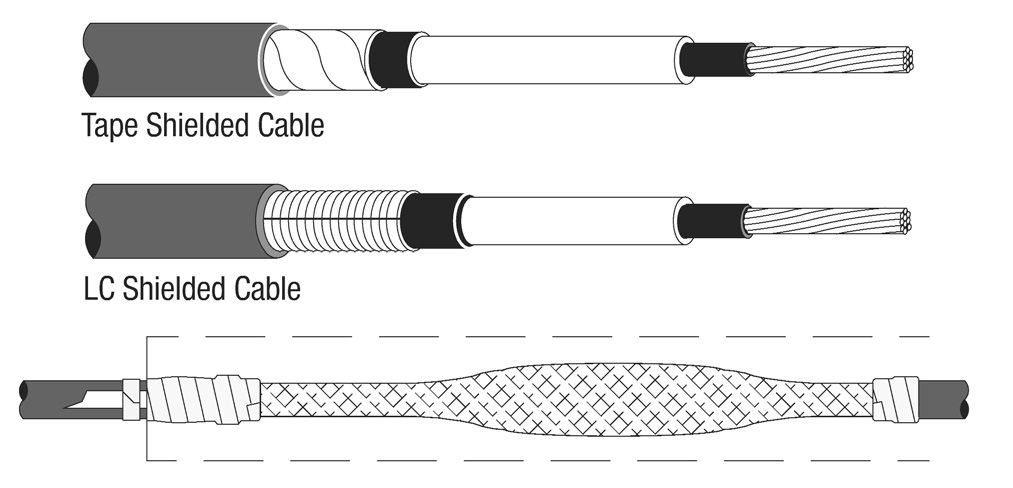

In [1]:
import requests
from PIL import Image
import torch
from transformers import BitsAndBytesConfig
from transformers import pipeline

url = "/media/pablo/windows_files/00 - Master/05 - Research&Thesis/R2-Research_Internship_2/02-data/0-testing/fitz_im_extractor_examples/ima1.jpeg"

image = Image.open(url)
image

In [2]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model_id = "llava-hf/llava-1.5-7b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 22.00 MiB. GPU 0 has a total capacity of 3.94 GiB of which 19.12 MiB is free. Including non-PyTorch memory, this process has 3.91 GiB memory in use. Of the allocated memory 3.78 GiB is allocated by PyTorch, and 88.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
max_new_tokens = 200
prompt = "USER: <image>\nDescribe in a tecnhical manner the content of the image\nASSISTANT:"
# outputs = pipe(image, prompt=prompt, temp = 0.1, generate_kwargs={"max_new_tokens": 200}) #test, dont know if it works
outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
print(outputs[0]["generated_text"])

LlaMa3 - without 4bits quantization


In [ ]:
print(
    model.answer_question(
        image, "Describe in a technical manner the content of the image", tokenizer, max_new_tokens=128, do_sample=True, temperature=0.3
    ),
)

Llama3 with 4bits quantization

--------------------------------

Florence Ai test

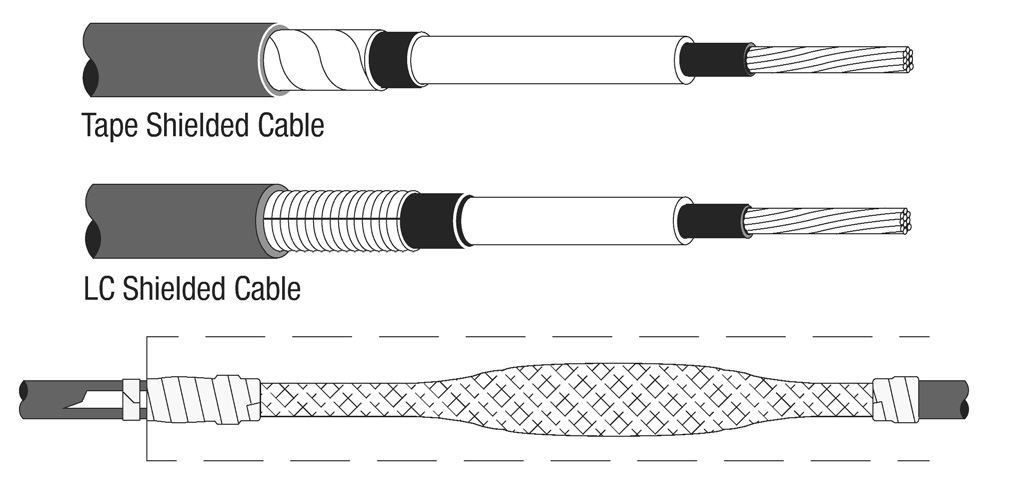

In [8]:

image_path = "../02-data/0-testing/images/ima1.jpeg"
image = Image.open(image_path).convert('RGB')
image

In [11]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM 

print(f"Is cuda available? : {torch.cuda.is_available()}")
#device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

prompt = "Describe in a technical manner the content of the image"

image_path = "../02-data/0-testing/images/ima1.jpeg"
image = Image.open(image_path).convert('RGB') #expects 3 channels, greyscale image has less, and thus, fails

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3,
    do_sample=False
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task=prompt, image_size=(image.width, image.height))

print(parsed_answer)

Is cuda available? : True


preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/home/pablo/.cache/huggingface/modules/transformers_modules/microsoft/Florence-2-base/ceaf371f01ef66192264811b390bccad475a4f02/processing_florence2.py:499: SyntaxWarning: invalid escape sequence '\d'
  """


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

{'Describe in a technical manner the content of the image': 'The image shows three different types of cables, each with a different length and width. The first cable is labeled "Tape Shielded Cable" and the second cable is labelled "LC Shielded Cable". The third cable has a curved shape with a pointed end and a flat end. All three cables have a black and white color scheme.'}


In [12]:

image_path = "../02-data/0-testing/images/ima2.png"
image = Image.open(image_path).convert('RGB') #expects 3 channels, greyscale image has less, and thus, fails

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3,
    do_sample=False
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task=prompt, image_size=(image.width, image.height))

print(parsed_answer)

{'Describe in a technical manner the content of the image': 'The image shows a close-up of a cable holder with multiple wires in it. The wires are of different colors and sizes, and they are arranged neatly in the holder. The holder is black in color and has a cylindrical shape.'}
